# Tutorial 1: The Basics

In this tutorial, we will go through a guided example of how to generate a new database for your MD simulation.

The first step is to import the necessary packages. For this tutorial, we will only be using the data processing capabilities of the class, as well as some simple os functionality to show the existence of new files, therefore, only the mdsuite and os packages are required.

In [1]:
import mdsuite as mds # Cool name for professionalism purposes
import os

The workhorse of the mdsuite package is the trajectory class. We have to make an instance of this class for each system we wish to study. In this tutorial, we will look at the two noble gas systems, argon and krypton. In the case of these simulations, both systems are in their liquid state. Note that if you run this program in terminal, or if you have your jupyter set up better than mine, a progress bar will render in the notebook to give you an estimate of the time left in the database construction.

In [2]:
argon_85K = mds.Experiment(analysis_name="argon_85K", 
                           new_project=True,
                          storage_path=".",
                          temperature=85.0,
                          time_step=0.002,
                          time_unit=1e-12,
                          filename="trajectory_files/Ar_85K.dump",
                          length_unit=1e-10)
krypton_85K = mds.Experiment(analysis_name="krypton_85K", 
                           new_project=True,
                          storage_path=".",
                          temperature=85.0,
                          time_step=0.002,
                          time_unit=1e-12,
                          filename="trajectory_files/Kr_85K.dump",
                          length_unit=1e-10)

  0%|          | 0/5 [00:00<?, ?it/s]

Beginning Build database


  0%|          | 0/5 [00:00<?, ?it/s]


 ** Database has been constructed and saved for argon_85K ** 

Beginning Build database


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]



 ** Database has been constructed and saved for krypton_85K ** 



In order to break down what has happened, I will discuss in brief what each of these attributes are and how to input them.

* **analysis_name:** This is the name of the project that has been created. The directory that the program has just created, along with the hdf5 database, will share this name. This is always required, whether it is a new project, or you are loading an old one
* **new_project:** If this is set to False, the program will attempt to load a class instance and database with the analysis name. If True, a new database will be created.
* **storage_path:** For bigger projects, you may wish to store the database and files on a different drive. This allows you to choose where you wish to store the files. It is always required for new projects and old.
* **temperature:** Temperature of the system. If the temperature changes during the simulation, give it the initial, or average temperature. This parameter is currently only used on the conductivity calculations, therefore, it isn't necessary for much of the analysis
* **time_step:** Give the time step of the simulation. This will allow the class to accurately model the time
* **length_unit:** The unit of length (pm, um, angstrom)
* **filename:** Where the dump file is
* **time_unit:** Unit of time (ps, ns, us)

Note, if the project is to be loaded, all that is required is the storage_path, analysis_name, and new_project=False attributes. The rest need not be included as the class state will be loaded

So let's looks now at the directory

In [3]:
for item in os.listdir("."):
    print(f"{item}\n")

lammps_scripts

trajectory_files

Tutorial_1.ipynb

Tutorial_2.ipynb

__pycache__

.ipynb_checkpoints

NaCl_1400K

conductivity_thermal

MDSuite_Demonstration.html

argon_85K

krypton_85K



There are two new directories now names argon_85K and krypton_85K. Opening one of these directories, we can see what the program has done so far.

In [4]:
for item in os.listdir("argon_85K"):
    print(f"{item}\n")

argon_85K.hdf5

argon_85K.bin



Two files have been created in the argon directory, one, a hdf5 database, and the other a txt file with the state of the class. Unless you have some specific interest, it is unnecessary to do anything in this directory, as all of the information can be accessed from within the class. For example, one useful method is print_class_attributes, which will print a list of the class attributes that have been calculated during the database construction

In [5]:
argon_85K.print_class_attributes()

filename: trajectory_files/Ar_85K.dump
analysis_name: argon_85K
new_project: True
filepath: .
temperature: 85.0
time_step: 0.002
time_unit: 1e-12
length_unit: 1e-10
sample_rate: 20.0
batch_size: 1000
volume: 5574.383217238844
species: {'Ar': {'indices': [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116], 'charge': [0], 'mass': [35.9675451, 37.962732, 39.96238312, None]}}
number_of_atoms: 108
properties: {'x': 3, 'y': 4, 'z': 5, 'vx': 6, 'vy': 7, 'vz': 8, 'fx': 9, 'fy': 10, 'fz': 11}
property_groups: {'Positions': [3, 4, 5], 'Velocities': [6, 7, 8], 'Forces': [9, 10, 11]}
dimensions: 3
box_array:

[('filename', 'trajectory_files/Ar_85K.dump'),
 ('analysis_name', 'argon_85K'),
 ('new_project', True),
 ('filepath', '.'),
 ('temperature', 85.0),
 ('time_step', 0.002),
 ('time_unit', 1e-12),
 ('length_unit', 1e-10),
 ('sample_rate', 20.0),
 ('batch_size', 1000),
 ('volume', 5574.383217238844),
 ('species',
  {'Ar': {'charge': [0],
    'indices': [9,
     10,
     11,
     12,
     13,
     14,
     15,
     16,
     17,
     18,
     19,
     20,
     21,
     22,
     23,
     24,
     25,
     26,
     27,
     28,
     29,
     30,
     31,
     32,
     33,
     34,
     35,
     36,
     37,
     38,
     39,
     40,
     41,
     42,
     43,
     44,
     45,
     46,
     47,
     48,
     49,
     50,
     51,
     52,
     53,
     54,
     55,
     56,
     57,
     58,
     59,
     60,
     61,
     62,
     63,
     64,
     65,
     66,
     67,
     68,
     69,
     70,
     71,
     72,
     73,
     74,
     75,
     76,
     77,
     78,
     79,
     80,
     8

So we can see that atom species information, configurations information, property information, volume, box size, and some more time information, has been extracted from the LAMMPS dump. All of this will become helpful in our analysis.

So now that we have seen how to prepare a new project, let's look at some analysis that can be done with each, starting with the unwrapping of particle coordinates. Unless LAMMPS has printed unwrapped coordinates for you, this must be done in order to calculate dynamic properties using Einstein methods. Therefore, let's unwrap the coordinates. Note, in principle this is not necessary, if you try to run an Einstein method without Unwrapped coordinates, the program will simply unwrap them for you to make sure it can be run.

In [6]:
argon_85K.unwrap_coordinates()
krypton_85K.unwrap_coordinates()


 --- Beginning to unwrap coordinates --- 

108
5000

 --- Finished unwrapping coordinates --- 


 --- Beginning to unwrap coordinates --- 

108
5000

 --- Finished unwrapping coordinates --- 



With the coordinates unwrapped, we can start looking at some interesting physical properties, such as the Einstein self-diffusion coefficients.

To do this, we simply call the Einstein_Self_Diffusion method, with the plot argument set to True.

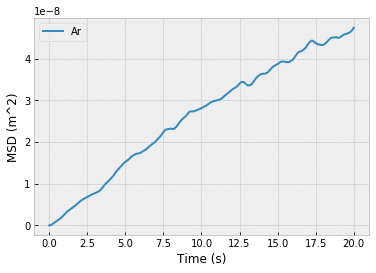

In [7]:
argon_85K.einstein_diffusion_coefficients(plot=True)

The return of this function, as you can see, is the self-diffusion coefficient for the argon system, as well as a plot of the msd with time.

Let's do the same now for krypton and argon to see how they compare

In [8]:
argon_85K.einstein_diffusion_coefficients()
krypton_85K.einstein_diffusion_coefficients()

Now we are just looking at the values because the plot argument is set False by default. The Krypton system however, is a perfect example of why this isn't always a good idea. Note the negative diffusion value, this is a little strange. So we look first at the msd to see if we can understand what has gone wrong.

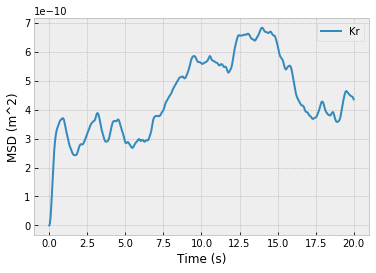

In [9]:
krypton_85K.einstein_diffusion_coefficients(plot=True)

This shows an odd msd for what we assumed was a liquid system. In order to check this we should recall the temperature of the system.

In [10]:
krypton_85K.temperature

85.0

A quick comparison with literature would tell you that at this temperature, krypton happens to be solid, explaining why these results are being seen. Still, it doesn't mean that nothing is going on in the crystal, as occasionally some diffusion may still occur. For this, we should look at an alternative method, namely, the Green-Kubo approach.

We can do this simply here by calling the Green_Kubo_Diffusion_Coefficients method, again, with the plot set equal to True

100%|██████████| 100/100 [00:08<00:00, 11.45it/s]


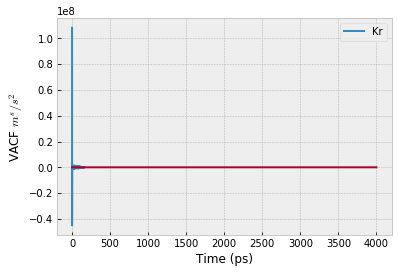

In [11]:
krypton_85K.green_kubo_diffusion_coefficients(data_range=4000, plot=True)

In [12]:
argon_85K.green_kubo_ionic_conductivity(plot=True, data_range=1000)

IndexError: list index out of range

You will note that this analysis takes a little longer. This is due not to the algorithm being implemented, but rather the error analysis being performed. By selecting a sample of the data, say 4000 points, we can sample the autocorrelation function at various parts of the trajectory, thus allowing us to the calculate an error for the diffusion coefficients. It is this repetition which takes a long time. In a future release, we will implement a means to calculate the correlation time of your data, and both improve the sampling time of this algorithm, but ensure truly decorrelated and accurate error calculations.

So now we can see a little better the results of this analysis. There may indeed be some minor diffusion through the bulk but is is at an extremely slow rate. In reality, one shouldn't use this method of analysis to study solid state diffusion, rather a more detailed study of single atoms should be performed. In principle, this can be done by changing some of the code in this package quite trivially, but you should contact me if this becomes necessary.